<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalacion de paquetes**

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [ ]:
!pip install mne

     |████████████████████████████████| 6.9 MB 10.4 MB/s 


# **Importa paquetes**



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
from scipy.signal import butter, lfilter
from sklearn import decomposition

from google.colab import drive
from google.colab import files

import sys
import mne

from scipy.signal import find_peaks
#from sklearn.cluster import KMeans

# Carga de datos

**En la carpeta 2021_DMCT/datos_eeg/ se sube el archivo crudos.zip**.

**Los datos quedan accesibles en la carpeta content/crudos**



In [ ]:
!wget https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/crudos.zip

--2021-08-31 21:04:48--  https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/crudos.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48316250 (46M) [application/zip]
Saving to: ‘crudos.zip’

crudos.zip          100%[===================>]  46.08M   237MB/s    in 0.2s    

2021-08-31 21:04:49 (237 MB/s) - ‘crudos.zip’ saved [48316250/48316250]



In [ ]:
!unzip "crudos.zip" 

Archive:  crudos.zip
  inflating: crudos/suj_7_bl_1_crudos.txt  
  inflating: crudos/suj_15_bl_2_crudos.txt  
  inflating: crudos/suj_8_bl_2_crudos.txt  
  inflating: crudos/suj_10_bl_1_crudos.txt  
  inflating: crudos/suj_13_bl_1_crudos.txt  
  inflating: crudos/suj_17_bl_2_crudos.txt  
  inflating: crudos/suj_11_bl_1_crudos.txt  
  inflating: crudos/suj_9_bl_2_crudos.txt  
  inflating: crudos/suj_14_bl_2_crudos.txt  
  inflating: crudos/suj_7_bl_2_crudos.txt  
  inflating: crudos/suj_12_bl_2_crudos.txt  
  inflating: crudos/suj_16_bl_1_crudos.txt  
  inflating: crudos/suj_14_bl_1_crudos.txt  
  inflating: crudos/suj_10_bl_2_crudos.txt  
  inflating: crudos/suj_15_bl_1_crudos.txt  
  inflating: crudos/suj_16_bl_2_crudos.txt  
  inflating: crudos/suj_13_bl_2_crudos.txt  
  inflating: crudos/suj_17_bl_1_crudos.txt  
  inflating: crudos/suj_9_bl_1_crudos.txt  
  inflating: crudos/suj_18_bl_1_crudos.txt  
  inflating: crudos/suj_8_bl_1_crudos.txt  
  inflating: crudos/suj_11_bl_2_crudos.t

In [ ]:
sys.path.append('/content/crudos')

## (1) Levanto datos de EEG

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo es de 256 Hz.

**Aclaración Flavia: Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"**

In [ ]:
filename = '/content/crudos/suj_1_bl_1_crudos.txt'
datos = pd.read_csv(filename, sep=',', header=None)
EEGdata = datos.to_numpy()
srate=256
ch    = EEGdata.shape[0]
samples = EEGdata.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(EEGdata.shape[1], EEGdata.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 256.00 Hz
Data shape: 30720 samples x 30 channels
Tiempo total : 120.00 


Los registros fueron tomados con el montage 10-20.

**La nariz es fpz**.
Tengo que armarlo que los electrodos tengan esta distribución:
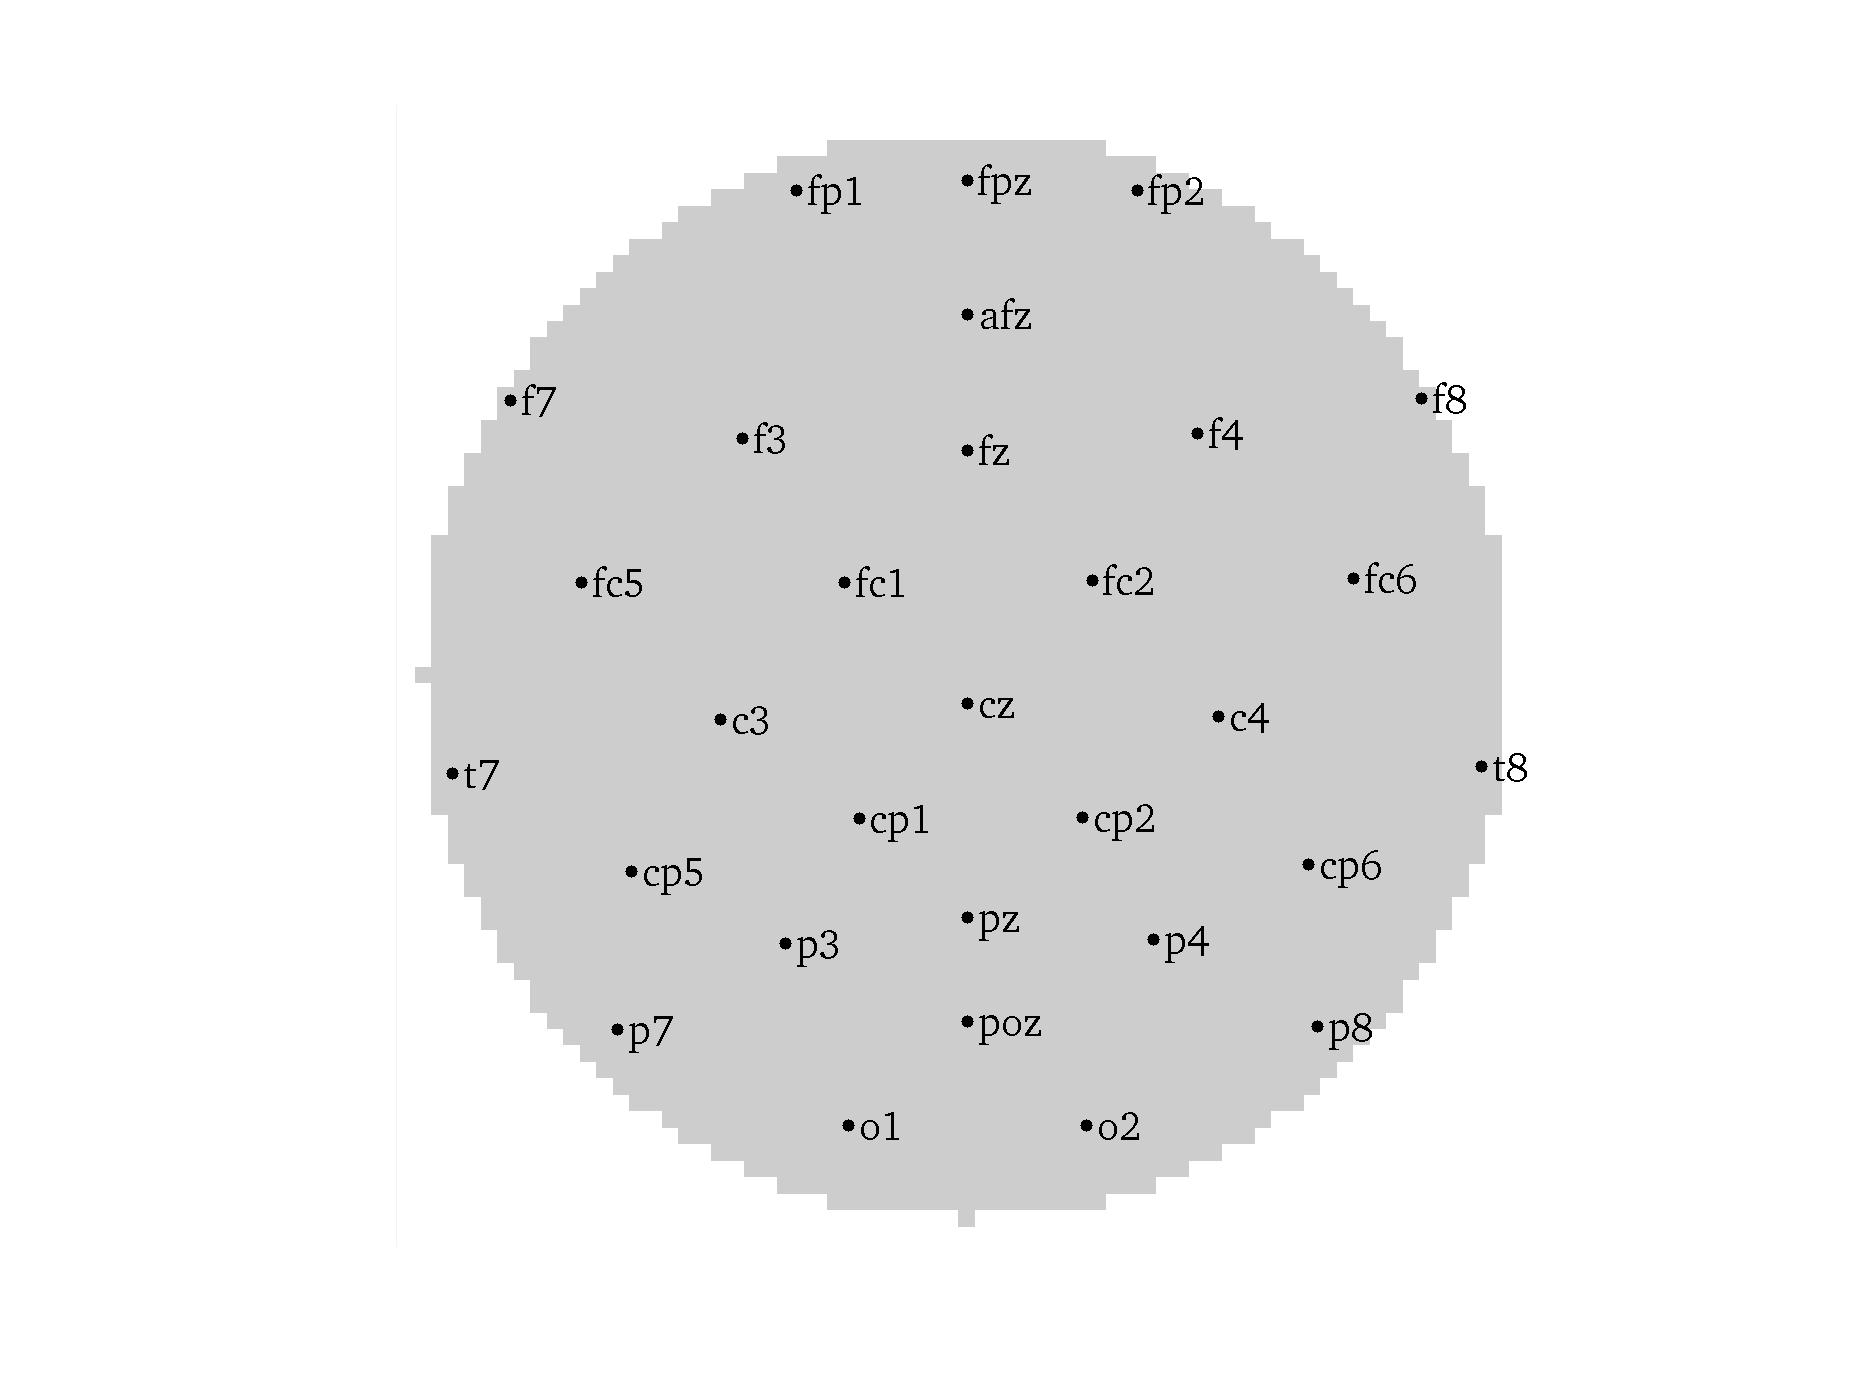

In [ ]:
# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

# (1.bis) Inspección de los datos crudos

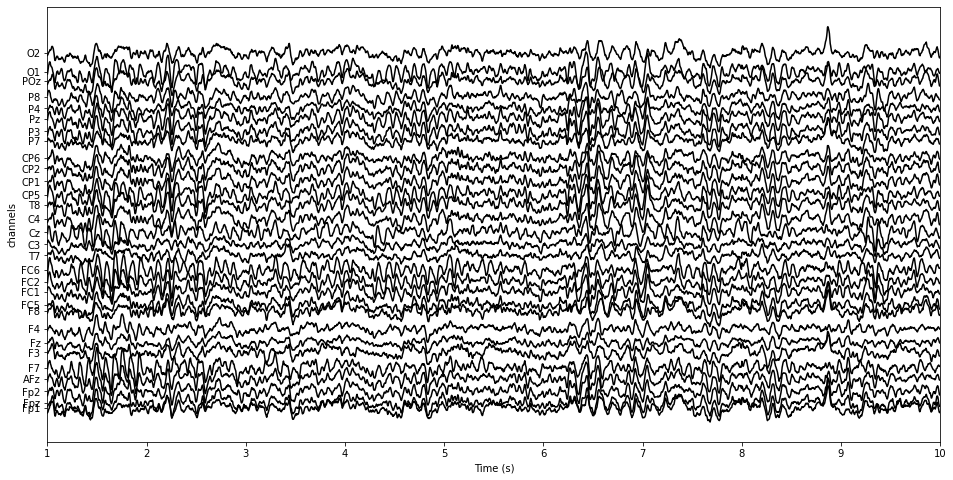

In [ ]:
inicio = 1
fin    = 10
xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
fig,ax = plt.subplots(ncols=1,figsize=(16,8))
#fig.suptitle('Series temporales (uV)')
yticks=[]
for c in np.arange(ch):
    temp = EEGdata[c,inicio*srate:fin*srate]
    dmin=np.min(temp)
    dmax=np.max(temp)
    vmedio = np.mean([dmin,dmax])+30*c
    yticks.append(vmedio)
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'k')
ax.set_xlim([inicio*srate,fin*srate])
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(inicio,fin+1))
ax.set_yticks(yticks)
ax.set_yticklabels(mont1020_30.ch_names)
ax.set_ylabel('channels')
ax.set_xlabel('Time (s)')
  
plt.show()

## (2) Pre-procesado

Defino un filtro Butterworth de 6to orden que a partir de Scipy. Filtro entre 1 y 35 Hz
 contains a zero-phase 6-th order Butterworth band-pass filter as provided by SciPy. The input is (1) the data to be filtered as a NumPy array of shape (n_samples, n_channels), (2) a tuple defining the desired frequency band in Hz, and (3) the EEG sampling rate in Hz.

Las señales filtradas se llaman EEG_data_filt.

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



# Sample rate and desired cutoff frequencies (in Hz).
lowcut = 2
highcut = 20
order = 6
EEGdata_filt = np.zeros_like(EEGdata)
for i,temp_canal in enumerate(EEGdata):
  EEGdata_filt[i,:] = butter_bandpass_filter(temp_canal, lowcut, highcut, srate, order)


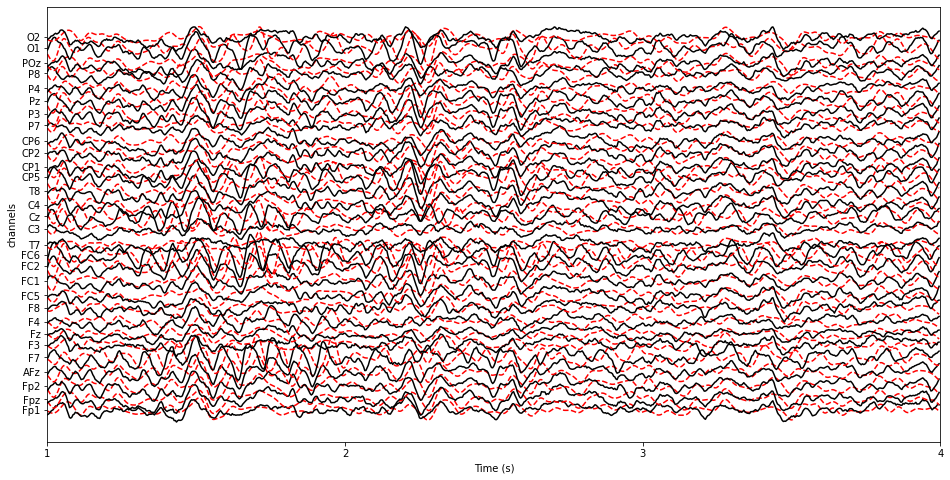

In [ ]:
inicio = 1
fin    = 4
xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
fig,ax = plt.subplots(ncols=1,figsize=(16,8))
#fig.suptitle('Series temporales (uV)')
yticks=[]
for c in np.arange(ch):
    temp = EEGdata_filt[c,inicio*srate:fin*srate]
    temp2=EEGdata[c,inicio*srate:fin*srate]
    dmin=np.min(temp)
    dmax=np.max(temp)
    vmedio = np.mean([dmin,dmax])+30*c
    yticks.append(vmedio)
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'--r')
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp2)+temp2,'k')
ax.set_xlim([inicio*srate,fin*srate])
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(inicio,fin+1))
ax.set_yticks(yticks)
ax.set_yticklabels(mont1020_30.ch_names)
ax.set_ylabel('channels')
ax.set_xlabel('Time (s)')
  
plt.show()

Text(0.5, 0, 'Time (s)')

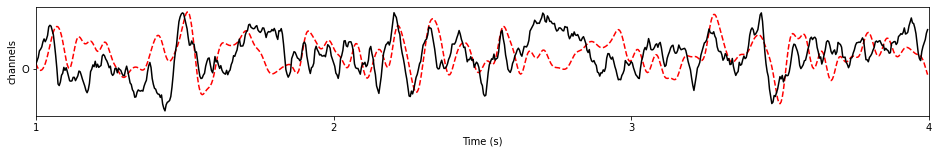

In [ ]:
fig,ax=plt.subplots(ncols=1,figsize=(16,2))
ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'--r')
ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp2)+temp2,'k')
ax.set_xlim([inicio*srate,fin*srate])
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(inicio,fin+1))
ax.set_yticks([860])
ax.set_yticklabels(mont1020_30.ch_names[c-1])
ax.set_ylabel('channels')
ax.set_xlabel('Time (s)')
  

Topología


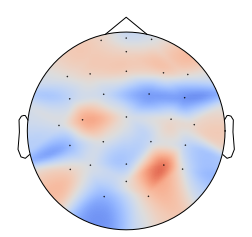

In [ ]:
fig, ax = plt.subplots( figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)


im,cm   = mne.viz.plot_topomap(EEGdata_filt[:,inicio*srate:fin*srate].mean(axis=1),info_eeg,vmin=-0.05,vmax=0.3,
                     cmap='coolwarm', contours=0, show=True)
ax.set_title('topogragía promedio')
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
    #clb.ax.set_title(unit_label,fontsize=fontsize) # title on top of colorbar
   # plt.show()     

## (3) Descomposición (PCA-1)

(30, 3)


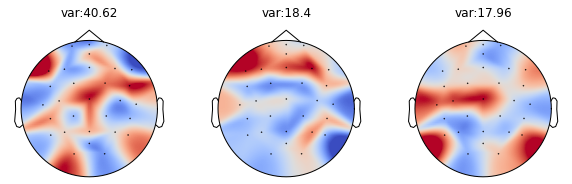

In [ ]:
pca = decomposition.PCA(n_components=3)
pca.fit(EEGdata_filt)
pcs = pca.transform(EEGdata_filt)
print(pcs.shape)
var = pca.explained_variance_ratio_
fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for p in range(pcs.shape[1]):
  mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax[p],show=False)
  ax[p].set_title('var:'+str(round(var[p]*100,2)) )      

# **Obtención de features**

**Por ahora solo se disponen de las señales crudas de un archivo (de una persona) La profesora va a entregar los datos ya procesados, filtrados y remuestreados a 128 con los cuales se tendrá que trabajar**. 


**Por ahora se trabaja con las señales filtradas con el filtro pasabanda pero no se redujo la cantidad de muestras a 128**.

**Estos datos corresponden a 1 archivo de 1 persona**

In [ ]:
EEGdata_filt.shape

(30, 30720)

**Para los cálculos a continuación uso ref** https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf

**Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{U_{i}}$   donde $c$ es la cantidad total de canales y $U_{i}$ es la medición del i-ésimo canal**.

**Entonces el *average reference* se calcula $u_i=U_i-\bar{u}$**

In [ ]:
u_mean=np.mean(EEGdata_filt,axis=0)  # axis=0 calcula para cada n-esima muestra
u_mean.shape

(30720,)

In [ ]:
u_i=EEGdata_filt-u_mean

**De acuerdo a la referencia el *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}u_{i}^2}$  y es equivalente al desvio estándar de los electrodos (en un cierto tiempo *t* o muestra *n*)**.

In [ ]:
sx_std=np.std(u_i,axis=0)

In [ ]:
len(sx_std)

30720

defino el tiempo

In [ ]:
t=np.arange(0,120,1/srate)

**Las otras figuras están ploteadas entre 1 y 4 segundos. Sin embargo se tienen datos durante 120 segundos. La varianza obtenida se dibuja para el tiempo total**. 

In [ ]:
srate*150*1e-3

38.4

**Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=25 y con la frecuencia de muestreo de 256 Hz los picos deberán estar alejados en no menos de 100 ms (aproximadamente)**.

In [ ]:
25/srate

0.09765625

In [ ]:
peaks, _ = find_peaks(sx_std, height=0,prominence=1,distance=25)#,width=12,prominence=2)

In [ ]:
print(len(peaks))
print(120/len(peaks))

792
0.15151515151515152


Text(0.5, 0, 'Time (s)')

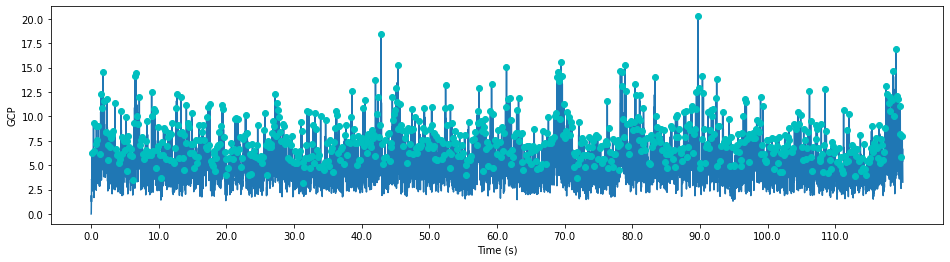

In [ ]:
fig,ax=plt.subplots(ncols=1,figsize=(16,4))

xticks = np.arange(t[0],t[-1],10)
ax.plot(t,sx_std)
ax.plot(t[peaks],sx_std[peaks],'co')
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(t[0],t[-1],10))
ax.set_xticks(xticks)
ax.set_ylabel('GCP')
ax.set_xlabel('Time (s)')

**El remuestreo se hace con rangos calculados por la distancia entre picos**

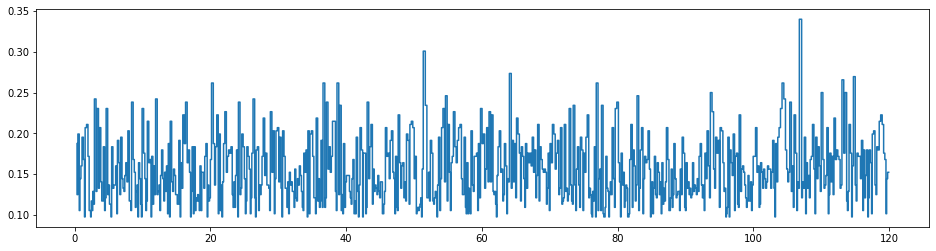

In [ ]:
fig,ax=plt.subplots(ncols=1,figsize=(16,4))
plt.step(t[peaks[1:]],np.diff(t[peaks]))


**valores mínimos y máximos entre picos consecutivos**

In [ ]:
print(min(np.diff(t[peaks])))
print(max(np.diff(t[peaks])))

0.09765625
0.33984375


**Para cada uno de los períodos identificados (de largo variable) se calcula la media de $u_{i}$. ESTO HAY QUE CONFIRMARLO**

In [ ]:
data=[];
for jj in np.arange(0,len(peaks)-1):
  data.append(np.mean(u_i[:,np.arange(peaks[jj],peaks[jj+1])],axis=1))

In [ ]:
len(data)
import pandas as pd
df = pd.DataFrame(data)
df.columns=mont1020_30.ch_names

In [ ]:
#np.arange(peaks[0],peaks[1])
#z=(u_i[:,np.arange(peaks[jj],peaks[jj+1])])
#z.shape

In [ ]:
df

,Fp1,Fpz,Fp2,AFz,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,CP5,CP1,CP2,CP6,P7,P3,Pz,P4,P8,POz,O1,O2
0,0.601949,-0.435651,-0.329363,-0.902031,-0.511316,-0.570306,-0.820767,-0.565389,1.764568,1.301870,0.713249,-0.213992,-1.441513,1.647750,0.234506,-0.702708,0.172837,0.095271,-0.681481,-0.729769,0.574409,-0.007076,0.598139,-0.557396,-0.197008,-0.466820,0.096347,0.221275,-0.635052,1.745469
1,0.197391,0.830888,0.728990,2.002977,2.121417,2.660061,2.489512,2.247421,-1.802757,-3.335243,-1.790836,0.103628,1.362674,-3.415971,-1.990772,-0.707013,-0.848960,-1.278613,1.682844,0.797912,-1.959790,1.186087,-1.928953,0.647222,0.208827,2.172469,-0.888810,-0.940721,1.619411,-2.171291
2,0.652564,-0.250303,-0.197171,-1.047819,-1.350737,-1.024824,-1.004847,-1.126665,0.838005,1.954868,0.921816,-0.979454,-1.097219,2.473148,1.877484,0.303763,-0.133749,0.412122,-1.601815,-0.447415,0.979545,-0.821860,1.922056,-0.378344,-0.716973,-0.922219,0.628879,0.187519,-1.483250,1.432894
3,1.334490,0.138170,-1.202906,-0.671207,-0.636527,3.143556,-1.928727,-4.001297,3.083889,-0.056544,-0.572196,0.584063,0.410215,-2.438264,-2.631953,-1.120585,1.892399,0.545004,1.501129,0.627415,0.493210,-0.992109,-0.954267,0.377695,1.246120,-0.211497,-0.971798,0.911416,1.266998,0.834108
4,-4.640372,-0.650162,1.942119,3.539840,3.147856,-5.873612,-0.191968,5.162542,-4.878189,-2.247768,0.073313,2.034406,2.071027,-0.952347,-0.520355,0.749004,-0.979367,0.698921,2.774657,0.210466,-1.298144,0.216674,-2.689024,2.249664,1.622152,-0.258333,0.159084,-0.608172,2.771517,-3.635429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,-1.355519,1.744452,1.776804,1.388957,0.129042,-2.393795,-1.822602,-0.118108,-0.756622,0.209019,0.993586,1.267221,0.036872,-1.749741,-1.642316,0.018254,1.571187,1.050588,1.063589,1.796664,1.086121,1.229483,-0.435033,1.235410,0.886032,-0.550400,-0.406245,1.444893,-7.832329,0.134533
787,2.430955,-1.156567,-1.457476,-1.196349,1.070667,4.320681,3.038503,1.112480,1.590430,-1.336357,-0.987382,-1.271800,-0.184324,1.143916,2.269848,0.064304,-2.423535,-1.621390,-1.029697,-2.131228,-1.969386,-0.458608,0.439016,-0.720514,-1.098308,1.313043,0.824571,-2.168131,1.769602,-0.176962
788,-4.642045,0.186042,0.650749,-0.185457,-2.428611,-8.259579,-5.547389,-2.045997,-3.155331,3.777588,3.291856,2.544324,-0.073855,-2.053107,-2.399067,0.687300,3.453212,3.148445,0.413730,2.098279,3.900425,-1.309530,0.329013,0.290382,2.274287,-3.997381,0.657796,2.026838,8.068299,-1.701215
789,0.881257,1.361953,1.381595,1.298708,0.218103,2.758486,0.976445,-0.544189,0.581905,-0.316925,-1.332731,-1.894103,-1.784222,0.312759,-0.762088,-1.952588,-0.330060,-1.008266,-0.234523,1.010373,-0.542573,1.676957,-0.812893,0.091442,-1.005568,2.358195,-1.148974,0.643463,-3.329820,1.447882


**Hago la misma descomposición de PCA, pero como en el dataframe quedaron en las columnas los nombres de los electrodos entonces primero aplico pca al dataset transpuesto (así repito lo que se hizo antes que no entiendo muy bien que hizo la profe)**.

**Hay que tomar con pinzas lo que viene después**.

(30, 3)


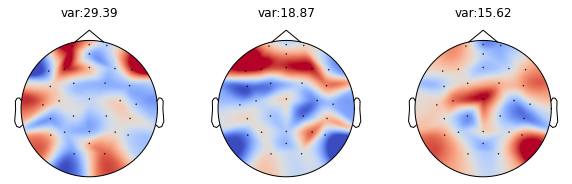

In [ ]:
pca = decomposition.PCA(n_components=3)
pca.fit(np.transpose(df))
pcs = pca.transform(np.transpose(df))
print(pcs.shape)
var = pca.explained_variance_ratio_
fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for p in range(pcs.shape[1]):
  mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax[p],show=False)
  ax[p].set_title('var:'+str(round(var[p]*100,2)) )  

**supongo que una vez que se tenga el dataframe se debe aplicar algún método para agrupar**

In [ ]:
#KMeans(n_clusters=6, random_state=0).fit(df)